In [45]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.express as px


In [46]:
raw_df = pd.read_csv('data/data.csv')

In [47]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16857 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   timestamp                     16857 non-null  object 
 1   equipment_energy_consumption  16013 non-null  object 
 2   lighting_energy               16048 non-null  object 
 3   zone1_temperature             15990 non-null  object 
 4   zone1_humidity                16056 non-null  object 
 5   zone2_temperature             16004 non-null  object 
 6   zone2_humidity                15990 non-null  float64
 7   zone3_temperature             16055 non-null  float64
 8   zone3_humidity                15979 non-null  float64
 9   zone4_temperature             16041 non-null  float64
 10  zone4_humidity                16076 non-null  float64
 11  zone5_temperature             16019 non-null  float64
 12  zone5_humidity                16056 non-null  float64
 13  z

In [48]:
raw_df.describe()

,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,zone4_humidity,zone5_temperature,zone5_humidity,zone6_temperature,zone6_humidity,zone7_temperature,...,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
count,15990.000000,16055.000000,15979.000000,16041.000000,16076.000000,16019.000000,16056.000000,16009.000000,16010.000000,16063.000000,...,16084.000000,15969.000000,16051.000000,16015.000000,16058.000000,16029.000000,16042.000000,16031.000000,16031.000000,16033.000000
mean,39.494553,21.665733,38.201314,20.239922,37.945608,19.052613,50.289131,6.469934,59.162913,19.672472,...,18.851085,40.318199,6.218582,755.757602,78.977595,4.195988,38.457150,2.783507,24.854981,25.093780
std,10.129513,2.594309,10.144388,2.783050,10.769813,2.346158,18.722516,8.867993,52.657787,2.879815,...,2.528783,11.168678,7.554684,13.643585,28.565660,4.409729,21.318655,6.094732,26.214960,25.523631
min,-77.265503,6.543921,-71.406273,4.613485,-81.446225,5.921094,-141.640143,-42.987365,-353.393026,3.578021,...,4.476511,-81.582494,-37.524768,678.159940,-221.668765,-20.929527,-82.329792,-32.098095,-120.170177,-120.409590
25%,37.757500,20.533333,36.592500,19.266667,35.200000,18.061111,45.290000,2.930000,37.066667,18.500000,...,17.890000,38.230000,3.000000,750.800000,71.000000,2.000000,29.000000,0.450000,12.179924,12.193789
50%,40.293333,21.767500,38.400000,20.290000,38.090000,19.050000,48.854429,6.263333,62.766667,19.600000,...,18.890000,40.363333,6.000000,756.200000,84.166667,4.000000,40.000000,2.750000,24.866978,24.834261
75%,43.000000,22.760000,41.433333,21.356667,41.560833,20.100000,53.918333,9.690000,86.590000,21.000000,...,20.200000,43.790000,9.250000,762.100000,91.988095,6.000000,40.000000,5.308333,37.950236,37.971764
max,77.265503,36.823982,71.406273,35.921144,81.446225,32.157594,141.640143,55.932271,353.393026,35.712952,...,33.238012,81.582494,49.853906,833.392675,221.668765,29.318719,159.606156,37.673716,170.156325,170.329617


### Converting the Columns into numeric form



In [49]:
#Converting the columns into correct data type for further use
raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'])
numeric_columns = [
    'equipment_energy_consumption',
    'lighting_energy',
    'zone1_temperature', 'zone2_temperature', 'zone3_temperature',
    'zone4_temperature', 'zone5_temperature', 'zone6_temperature',
    'zone7_temperature', 'zone8_temperature', 'zone9_temperature',
    'zone1_humidity', 'zone2_humidity', 'zone3_humidity',
    'zone4_humidity', 'zone5_humidity', 'zone6_humidity',
    'zone7_humidity', 'zone8_humidity', 'zone9_humidity',
    'outdoor_temperature', 'outdoor_humidity', 'atmospheric_pressure',
    'wind_speed', 'visibility_index', 'dew_point',
    'random_variable1', 'random_variable2'
]

for col in numeric_columns:
    raw_df[col] = pd.to_numeric(raw_df[col], errors='coerce')

### Performing outlier detection and fixing them 

In [50]:
# Create a processed dataframe for outlier handling
processed_df = raw_df.copy()

# Function to detect and fix outliers using hourly averages
def fix_outliers_with_hourly_avg(df, column):
    # Calculate Q1, Q3, and IQR for outlier detection
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    # Define bounds for outlier detection
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Create a mask for outliers
    outliers_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    # Count outliers before fixing
    outlier_count = outliers_mask.sum()
    
    if outlier_count > 0:
        print(f"Found {outlier_count} outliers in {column}")
        
        # Extract hour from timestamp for grouping
        df['hour'] = df['timestamp'].dt.hour
        
        # Calculate hourly averages for the column (excluding outliers)
        hourly_avg = df[~outliers_mask].groupby('hour')[column].mean()
        
        # Replace outliers with hourly averages
        for idx in df[outliers_mask].index:
            hour = df.loc[idx, 'hour']
            if hour in hourly_avg:
                df.loc[idx, column] = hourly_avg[hour]
            else:
                # If no hourly average available, use overall mean (excluding outliers)
                df.loc[idx, column] = df[~outliers_mask][column].mean()
        
        # Drop the temporary hour column
        df.drop('hour', axis=1, inplace=True)
    
    return outlier_count

# List of temperature and humidity columns to process
temperature_columns = [
    'zone1_temperature', 'zone2_temperature', 'zone3_temperature',
    'zone4_temperature', 'zone5_temperature', 'zone6_temperature',
    'zone7_temperature', 'zone8_temperature', 'zone9_temperature',
    'outdoor_temperature'
]

humidity_columns = [
    'zone1_humidity', 'zone2_humidity', 'zone3_humidity',
    'zone4_humidity', 'zone5_humidity', 'zone6_humidity',
    'zone7_humidity', 'zone8_humidity', 'zone9_humidity',
    'outdoor_humidity'
]

# Process all temperature columns in processed_df
print("Fixing temperature outliers with hourly averages:")
total_temp_outliers = 0
for col in temperature_columns:
    outliers_fixed = fix_outliers_with_hourly_avg(processed_df, col)
    total_temp_outliers += outliers_fixed

print(f"\nTotal temperature outliers fixed: {total_temp_outliers}")

# Process all humidity columns in processed_df
print("\nFixing humidity outliers with hourly averages:")
total_humidity_outliers = 0
for col in humidity_columns:
    outliers_fixed = fix_outliers_with_hourly_avg(processed_df, col)
    total_humidity_outliers += outliers_fixed

print(f"\nTotal humidity outliers fixed: {total_humidity_outliers}")



Fixing temperature outliers with hourly averages:
Found 633 outliers in zone1_temperature
Found 572 outliers in zone2_temperature
Found 380 outliers in zone3_temperature
Found 574 outliers in zone4_temperature
Found 356 outliers in zone5_temperature
Found 493 outliers in zone6_temperature
Found 359 outliers in zone7_temperature
Found 435 outliers in zone8_temperature
Found 341 outliers in zone9_temperature
Found 434 outliers in outdoor_temperature

Total temperature outliers fixed: 4577

Fixing humidity outliers with hourly averages:
Found 541 outliers in zone1_humidity
Found 629 outliers in zone2_humidity
Found 505 outliers in zone3_humidity
Found 521 outliers in zone4_humidity
Found 1497 outliers in zone5_humidity
Found 447 outliers in zone6_humidity
Found 572 outliers in zone7_humidity
Found 528 outliers in zone8_humidity
Found 594 outliers in zone9_humidity
Found 634 outliers in outdoor_humidity

Total humidity outliers fixed: 6468


In [51]:
# Check for negative values in lighting_energy in raw_df
negative_lighting_values = (raw_df['lighting_energy'] < 0).sum()
print(f"Number of negative values in lighting_energy in raw_df: {negative_lighting_values}")

# Display some examples of negative values
if negative_lighting_values > 0:
    print("\nSample of negative lighting_energy values in raw_df:")
    print(raw_df[raw_df['lighting_energy'] < 0]['lighting_energy'].head())

# Remove rows with negative values in lighting_energy from raw_df and save to processed_df
if negative_lighting_values > 0:
    print(f"\nRemoving {negative_lighting_values} rows with negative lighting_energy values from raw_df")
    processed_df = raw_df[raw_df['lighting_energy'] >= 0].copy()
else:
    processed_df = raw_df.copy()

Number of negative values in lighting_energy in raw_df: 229

Sample of negative lighting_energy values in raw_df:
0     -77.787786
31    -20.000000
72    -77.787786
115   -77.787786
143   -77.787786
Name: lighting_energy, dtype: float64

Removing 229 rows with negative lighting_energy values from raw_df


In [52]:
processed_df['lighting_energy'].describe()

count    15764.000000
mean         4.938372
std         11.685274
min          0.000000
25%          0.000000
50%          0.000000
75%         10.000000
max         86.002966
Name: lighting_energy, dtype: float64

In [53]:
# Outlier Capping for the Target Variable (Ensuring Lower Bound >= 10)

target_col = 'equipment_energy_consumption'

q1 = raw_df[target_col].quantile(0.25)
q3 = raw_df[target_col].quantile(0.75)
iqr = q3 - q1
calculated_lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Apply the domain knowledge: minimum consumption is 10
effective_lower_bound = max(10, calculated_lower_bound)

print(f"\nOutlier Capping for '{target_col}' (with lower bound >= 10):")
print(f"  Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}")
print(f"  Calculated Lower Bound (Q1 - 1.5*IQR): {calculated_lower_bound:.2f}")
print(f"  Effective Lower Bound (max(10, calculated)): {effective_lower_bound:.2f}")
print(f"  Upper Bound (Q3 + 1.5*IQR): {upper_bound:.2f}")

original_values = raw_df[target_col].copy() # To compare and count outliers

# Cap outliers using the effective lower bound
raw_df[target_col] = raw_df[target_col].clip(lower=effective_lower_bound, upper=upper_bound)

outliers_capped_lower = (original_values < effective_lower_bound).sum()
outliers_capped_upper = (original_values > upper_bound).sum()
total_outliers_capped = outliers_capped_lower + outliers_capped_upper

if total_outliers_capped > 0:
    print(f"Capped {total_outliers_capped} outliers in '{target_col}'.")
    print(f"  Values below {effective_lower_bound:.2f} capped: {outliers_capped_lower}")
    print(f"  Values above {upper_bound:.2f} capped: {outliers_capped_upper}")
else:
    print(f"No outliers found/capped in '{target_col}'.")

# Display the description after capping
print("\nDescription of target variable after outlier capping:")
print(raw_df[target_col].describe())


Outlier Capping for 'equipment_energy_consumption' (with lower bound >= 10):
  Q1: 50.00, Q3: 100.00, IQR: 50.00
  Calculated Lower Bound (Q1 - 1.5*IQR): -25.00
  Effective Lower Bound (max(10, calculated)): 10.00
  Upper Bound (Q3 + 1.5*IQR): 175.00
Capped 2187 outliers in 'equipment_energy_consumption'.
  Values below 10.00 capped: 314
  Values above 175.00 capped: 1873

Description of target variable after outlier capping:
count    15945.000000
mean        77.947005
std         45.022100
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max        175.000000
Name: equipment_energy_consumption, dtype: float64


In [54]:
raw_df.isnull().sum()

timestamp                         0
equipment_energy_consumption    912
lighting_energy                 864
zone1_temperature               949
zone1_humidity                  888
zone2_temperature               923
zone2_humidity                  867
zone3_temperature               802
zone3_humidity                  878
zone4_temperature               816
zone4_humidity                  781
zone5_temperature               838
zone5_humidity                  801
zone6_temperature               848
zone6_humidity                  847
zone7_temperature               794
zone7_humidity                  805
zone8_temperature               848
zone8_humidity                  777
zone9_temperature               773
zone9_humidity                  888
outdoor_temperature             806
atmospheric_pressure            842
outdoor_humidity                799
wind_speed                      828
visibility_index                815
dew_point                       826
random_variable1            

In [55]:
processed_df.head(20)

,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,...,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
1,2016-01-11 17:10:00,60.0,30.0,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.560000,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50.0,30.0,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,35.921144,...,17.000000,45.500000,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50.0,40.0,33.746609,46.066667,19.200000,44.590000,19.790000,45.000000,NaN,...,17.000000,45.400000,6.250000,733.800000,92.000000,6.000000,51.500000,37.673716,45.410389,45.410389
4,2016-01-11 17:40:00,60.0,40.0,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,4.476511,45.400000,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
5,2016-01-11 17:50:00,50.0,40.0,19.890000,46.026667,19.200000,44.500000,19.790000,44.933333,18.890000,...,17.000000,NaN,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,NaN
6,2016-01-11 18:00:00,60.0,50.0,19.890000,45.766667,19.200000,44.500000,19.790000,44.900000,35.921144,...,17.000000,NaN,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763
7,2016-01-11 18:10:00,60.0,50.0,19.856667,45.560000,19.200000,44.500000,19.730000,44.900000,18.890000,...,17.000000,45.290000,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890
8,2016-01-11 18:20:00,NaN,40.0,19.790000,45.597500,19.200000,44.433333,19.730000,44.790000,18.890000,...,17.000000,45.290000,5.933333,734.233333,91.666667,5.333333,40.000000,-32.098095,31.455702,31.455702
9,2016-01-11 18:30:00,70.0,40.0,19.856667,46.090000,19.230000,44.400000,19.790000,44.863333,18.890000,...,17.000000,45.290000,5.950000,734.300000,91.500000,5.500000,NaN,4.650000,3.089314,3.089314
10,2016-01-11 18:40:00,230.0,70.0,19.926667,45.863333,19.356667,44.400000,19.790000,44.900000,18.890000,...,NaN,45.290000,5.966667,734.366667,91.333333,NaN,40.000000,4.633333,10.298729,10.298729


### Handling the missing values

In [56]:
processed_df.isnull().sum()

timestamp                         0
equipment_energy_consumption    845
lighting_energy                   0
zone1_temperature               893
zone1_humidity                  828
zone2_temperature               858
zone2_humidity                  821
zone3_temperature               743
zone3_humidity                  822
zone4_temperature               770
zone4_humidity                  728
zone5_temperature               782
zone5_humidity                  761
zone6_temperature               798
zone6_humidity                  791
zone7_temperature               738
zone7_humidity                  749
zone8_temperature               797
zone8_humidity                  729
zone9_temperature               725
zone9_humidity                  825
outdoor_temperature             750
atmospheric_pressure            784
outdoor_humidity                752
wind_speed                      776
visibility_index                764
dew_point                       774
random_variable1            

In [57]:
# Check for missing values in the target variable (energy consumption)
target_col = 'equipment_energy_consumption'  # Define the target variable

# Count missing values in target variable before removal
missing_target_count = processed_df[target_col].isnull().sum()

if missing_target_count > 0:
    # Drop rows where target variable is missing
    processed_df = processed_df.dropna(subset=[target_col])
    print(f"Removed {missing_target_count} rows with missing values in target variable '{target_col}'")
    
    # Verify the removal
    remaining_missing = processed_df[target_col].isnull().sum()
    print(f"Remaining missing values in target variable: {remaining_missing}")
else:
    print(f"No missing values found in target variable '{target_col}'")



Removed 845 rows with missing values in target variable 'equipment_energy_consumption'
Remaining missing values in target variable: 0


In [58]:
# Handle missing values in the dataset
print("Handling missing values in the dataset...")

# First, let's check which columns have missing values
columns_with_nulls = processed_df.columns[processed_df.isnull().sum() > 0].tolist()
print(f"Columns with missing values: {columns_with_nulls}")

# For numerical columns, we'll impute missing values with mean or median
# First, let's add a date column if timestamp exists
if 'timestamp' in processed_df.columns:
    processed_df['date'] = pd.to_datetime(processed_df['timestamp']).dt.date

    # For each column with nulls, impute based on date
    for col in columns_with_nulls:
        if col != 'timestamp' and pd.api.types.is_numeric_dtype(processed_df[col]):
            # Create a copy of the column before imputation
            original_nulls = processed_df[col].isnull().sum()
            
            # Group by date and calculate mean for each date
            date_means = processed_df.groupby('date')[col].transform('mean')
            
            # First try to fill with date-specific means
            processed_df[col] = processed_df[col].fillna(date_means)
            
            # For any remaining nulls, use the overall median
            remaining_nulls = processed_df[col].isnull().sum()
            if remaining_nulls > 0:
                overall_median = processed_df[col].median()
                processed_df[col] = processed_df[col].fillna(overall_median)
                print(f"  - {col}: {original_nulls} nulls - {original_nulls - remaining_nulls} filled with date means, {remaining_nulls} filled with overall median")
            else:
                print(f"  - {col}: All {original_nulls} nulls filled with date means")
else:
    # If no timestamp column, use overall mean/median
    for col in columns_with_nulls:
        if pd.api.types.is_numeric_dtype(processed_df[col]):
            nulls_before = processed_df[col].isnull().sum()
            # Use median for imputation as it's more robust to outliers
            processed_df[col] = processed_df[col].fillna(processed_df[col].median())
            print(f"  - {col}: {nulls_before} nulls filled with overall median")

# Drop the date column if we created it
if 'date' in processed_df.columns:
    processed_df.drop('date', axis=1, inplace=True)

# Check if we still have missing values
remaining_nulls = processed_df.isnull().sum()
print("\nRemaining missing values after imputation:")
print(remaining_nulls[remaining_nulls > 0])


Handling missing values in the dataset...
Columns with missing values: ['zone1_temperature', 'zone1_humidity', 'zone2_temperature', 'zone2_humidity', 'zone3_temperature', 'zone3_humidity', 'zone4_temperature', 'zone4_humidity', 'zone5_temperature', 'zone5_humidity', 'zone6_temperature', 'zone6_humidity', 'zone7_temperature', 'zone7_humidity', 'zone8_temperature', 'zone8_humidity', 'zone9_temperature', 'zone9_humidity', 'outdoor_temperature', 'atmospheric_pressure', 'outdoor_humidity', 'wind_speed', 'visibility_index', 'dew_point', 'random_variable1', 'random_variable2']
  - zone1_temperature: 838 nulls - 837 filled with date means, 1 filled with overall median
  - zone1_humidity: All 785 nulls filled with date means
  - zone2_temperature: All 815 nulls filled with date means
  - zone2_humidity: All 779 nulls filled with date means
  - zone3_temperature: All 702 nulls filled with date means
  - zone3_humidity: All 767 nulls filled with date means
  - zone4_temperature: 727 nulls - 726 f

In [59]:
processed_df.isnull().sum()


timestamp                       0
equipment_energy_consumption    0
lighting_energy                 0
zone1_temperature               0
zone1_humidity                  0
zone2_temperature               0
zone2_humidity                  0
zone3_temperature               0
zone3_humidity                  0
zone4_temperature               0
zone4_humidity                  0
zone5_temperature               0
zone5_humidity                  0
zone6_temperature               0
zone6_humidity                  0
zone7_temperature               0
zone7_humidity                  0
zone8_temperature               0
zone8_humidity                  0
zone9_temperature               0
zone9_humidity                  0
outdoor_temperature             0
atmospheric_pressure            0
outdoor_humidity                0
wind_speed                      0
visibility_index                0
dew_point                       0
random_variable1                0
random_variable2                0
dtype: int64

In [60]:
processed_df.head(20)

,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,...,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
1,2016-01-11 17:10:00,60.0,30.0,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.560000,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50.0,30.0,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,35.921144,...,17.000000,45.500000,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50.0,40.0,33.746609,46.066667,19.200000,44.590000,19.790000,45.000000,21.002831,...,17.000000,45.400000,6.250000,733.800000,92.000000,6.000000,51.500000,37.673716,45.410389,45.410389
4,2016-01-11 17:40:00,60.0,40.0,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,4.476511,45.400000,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
5,2016-01-11 17:50:00,50.0,40.0,19.890000,46.026667,19.200000,44.500000,19.790000,44.933333,18.890000,...,17.000000,46.261771,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,25.583143
6,2016-01-11 18:00:00,60.0,50.0,19.890000,45.766667,19.200000,44.500000,19.790000,44.900000,35.921144,...,17.000000,46.261771,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763
7,2016-01-11 18:10:00,60.0,50.0,19.856667,45.560000,19.200000,44.500000,19.730000,44.900000,18.890000,...,17.000000,45.290000,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890
9,2016-01-11 18:30:00,70.0,40.0,19.856667,46.090000,19.230000,44.400000,19.790000,44.863333,18.890000,...,17.000000,45.290000,5.950000,734.300000,91.500000,5.500000,37.224069,4.650000,3.089314,3.089314
10,2016-01-11 18:40:00,230.0,70.0,19.926667,45.863333,19.356667,44.400000,19.790000,44.900000,18.890000,...,16.549701,45.290000,5.966667,734.366667,91.333333,6.073529,40.000000,4.633333,10.298729,10.298729
11,2016-01-11 18:50:00,580.0,60.0,20.066667,46.396667,19.426667,44.925960,19.790000,44.826667,19.000000,...,16.890000,45.290000,5.983333,734.433333,221.668765,5.833333,40.000000,4.616667,8.827838,25.583143


### Understanding Relations between differnt features?


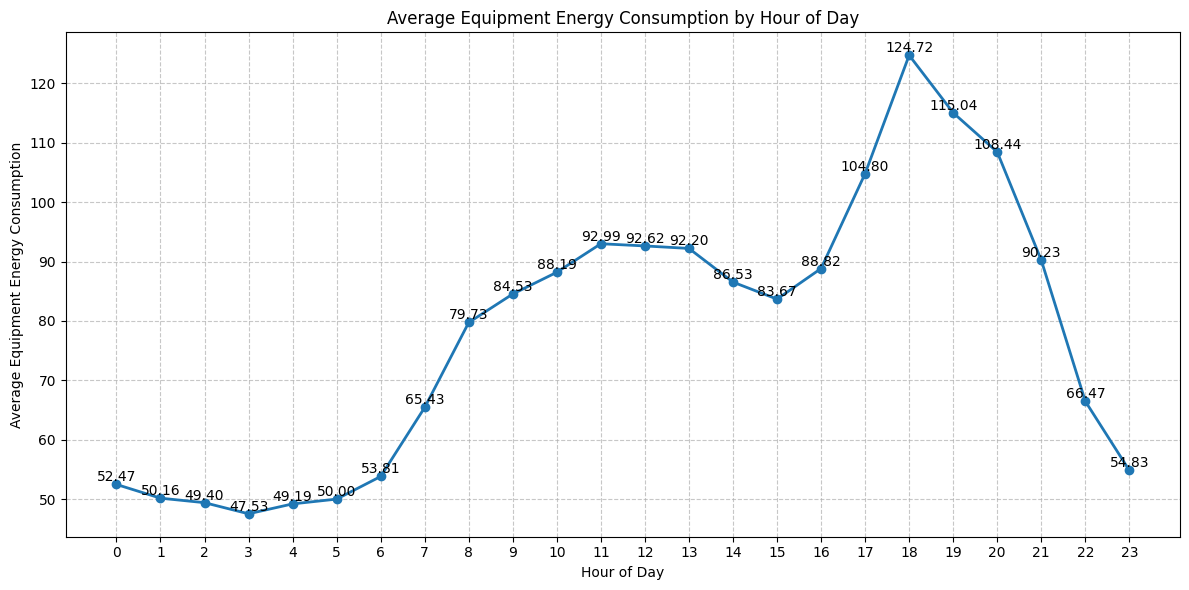

In [61]:
# Calculate average energy consumption by hour
# First, extract hour from the timestamp column if it exists
if 'timestamp' in raw_df.columns:
    raw_df['hour'] = pd.to_datetime(raw_df['timestamp']).dt.hour
    hourly_avg = raw_df.groupby('hour')['equipment_energy_consumption'].mean()
else:
    print("Error: No timestamp column found in the dataset")
    hourly_avg = pd.Series()  # Empty series if no timestamp column

# Create the plot only if we have data
if not hourly_avg.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linestyle='-', linewidth=2)
    plt.title('Average Equipment Energy Consumption by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Equipment Energy Consumption')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(0, 24))

    # Add value labels on top of each point
    for x, y in zip(hourly_avg.index, hourly_avg.values):
        plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
else:
    print("No data available for plotting")

In [62]:
# So basically from this we can see that the working hours of the factory is from morning 
# 7 am to around 10-11 pm in the night and the peak hour of production is around evening 6-7 pm

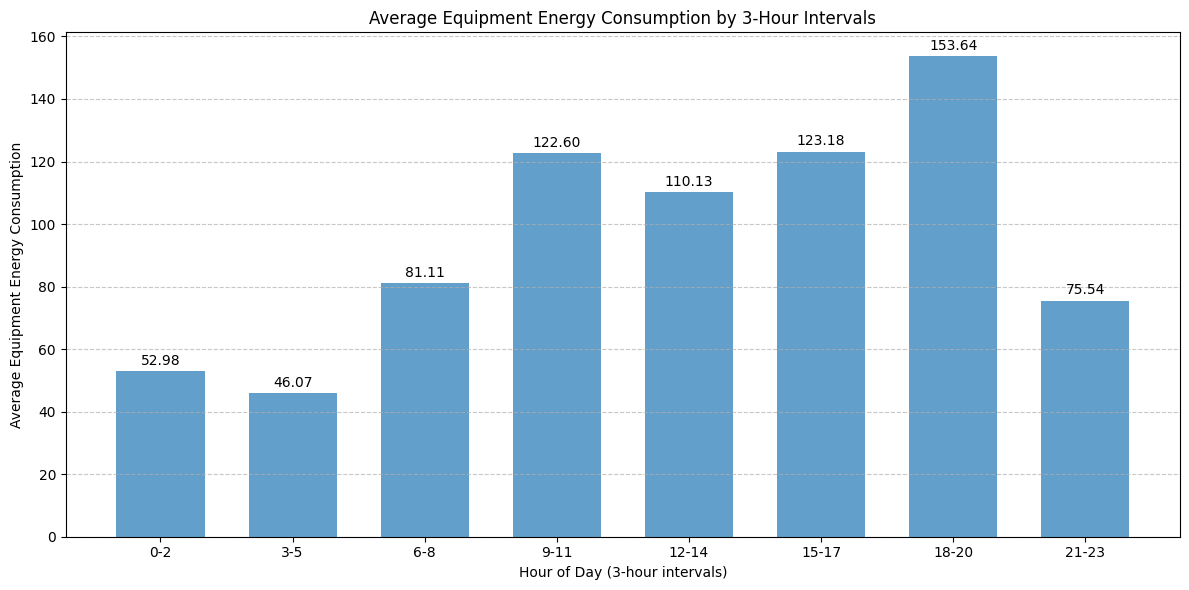

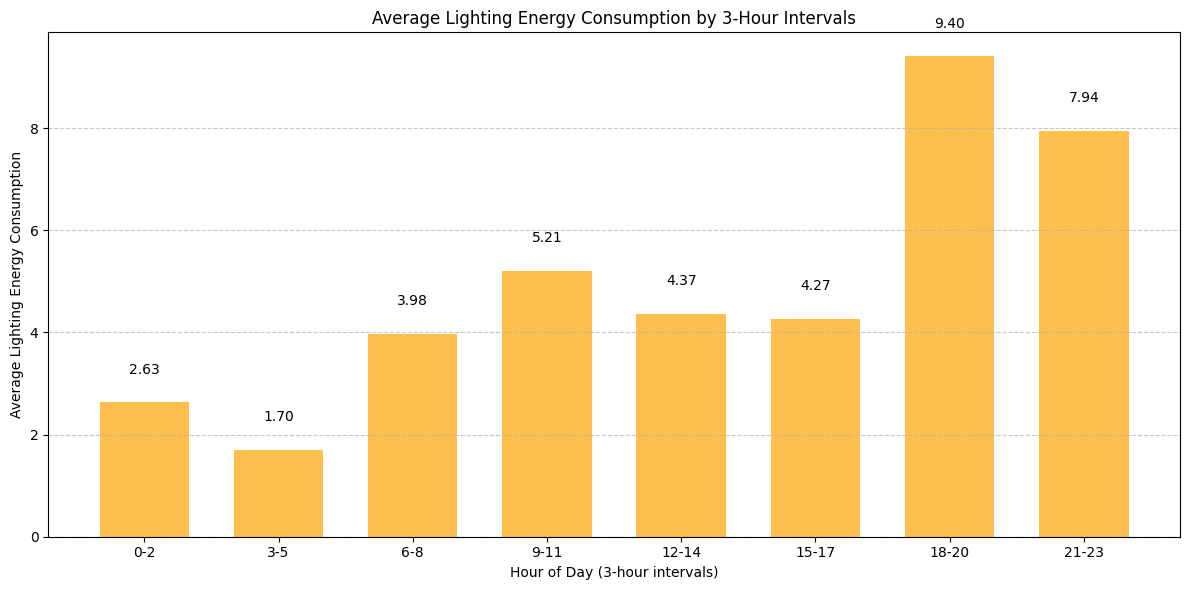

In [63]:
# Calculate average energy consumption by 3-hour intervals
if 'timestamp' in processed_df.columns:
    # Make sure timestamp is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(processed_df['timestamp']):
        processed_df['timestamp'] = pd.to_datetime(processed_df['timestamp'])
    
    # Extract hour from timestamp
    processed_df['hour'] = processed_df['timestamp'].dt.hour
    
    # Create 3-hour bins (0-2, 3-5, 6-8, etc.)
    processed_df['three_hour_bin'] = (processed_df['hour'] // 3) * 3
    
    # Group by 3-hour bins and calculate mean energy consumption
    three_hour_avg = processed_df.groupby('three_hour_bin')['equipment_energy_consumption'].mean()
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Create bar chart for 3-hour intervals
    bar_width = 2
    plt.bar(three_hour_avg.index, three_hour_avg.values, width=bar_width, alpha=0.7)
    
    plt.title('Average Equipment Energy Consumption by 3-Hour Intervals')
    plt.xlabel('Hour of Day (3-hour intervals)')
    plt.ylabel('Average Equipment Energy Consumption')
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    
    # Set x-ticks to show the start of each 3-hour interval
    plt.xticks(three_hour_avg.index, [f'{h}-{h+2}' for h in three_hour_avg.index])
    
    # Add value labels on top of each bar
    for x, y in zip(three_hour_avg.index, three_hour_avg.values):
        plt.text(x, y + 1, f'{y:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Also plot lighting energy in 3-hour intervals for comparison
    if 'lighting_energy' in processed_df.columns:
        three_hour_lighting = processed_df.groupby('three_hour_bin')['lighting_energy'].mean()
        
        plt.figure(figsize=(12, 6))
        plt.bar(three_hour_lighting.index, three_hour_lighting.values, width=bar_width, alpha=0.7, color='orange')
        plt.title('Average Lighting Energy Consumption by 3-Hour Intervals')
        plt.xlabel('Hour of Day (3-hour intervals)')
        plt.ylabel('Average Lighting Energy Consumption')
        plt.grid(True, linestyle='--', alpha=0.7, axis='y')
        plt.xticks(three_hour_lighting.index, [f'{h}-{h+2}' for h in three_hour_lighting.index])
        
        # Add value labels on top of each bar
        for x, y in zip(three_hour_lighting.index, three_hour_lighting.values):
            plt.text(x, y + 0.5, f'{y:.2f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
else:
    print("Error: No timestamp column found in the dataset")


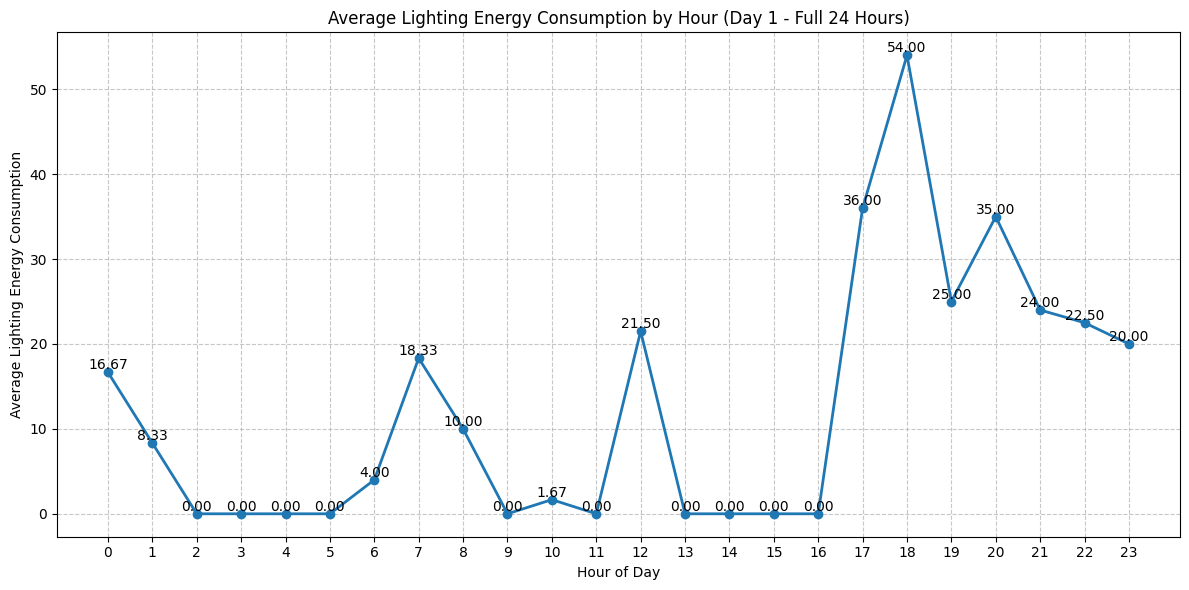

In [64]:
# Calculate average lighting energy consumption for all 24 hours of day 1
if 'timestamp' in processed_df.columns and 'lighting_energy' in processed_df.columns:
    # Make sure timestamp is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(processed_df['timestamp']):
        processed_df['timestamp'] = pd.to_datetime(processed_df['timestamp'])
    
    # Extract hour from timestamp
    processed_df['hour'] = processed_df['timestamp'].dt.hour
    
    # First, sort by timestamp to ensure chronological order
    processed_df = processed_df.sort_values('timestamp')
    
    # Get the start date
    start_date = processed_df['timestamp'].min()
    end_date = start_date + pd.Timedelta(days=1)
    
    # Filter data for just the first day
    day_one_data = processed_df[(processed_df['timestamp'] >= start_date) & 
                          (processed_df['timestamp'] < end_date)]
    
    # Group by hour and calculate mean for all 24 hours
    hourly_avg = day_one_data.groupby('hour')['lighting_energy'].mean()
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linestyle='-', linewidth=2)
    plt.title('Average Lighting Energy Consumption by Hour (Day 1 - Full 24 Hours)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Lighting Energy Consumption')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(0, 24))
    
    # Add value labels on top of each point
    for x, y in zip(hourly_avg.index, hourly_avg.values):
        plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
else:
    print("Error: Required columns not found in the dataset")


In [65]:
#As we can see that lighting energy consumption is high in from 5 pm to 12 am in the night due to the visibility of the factory


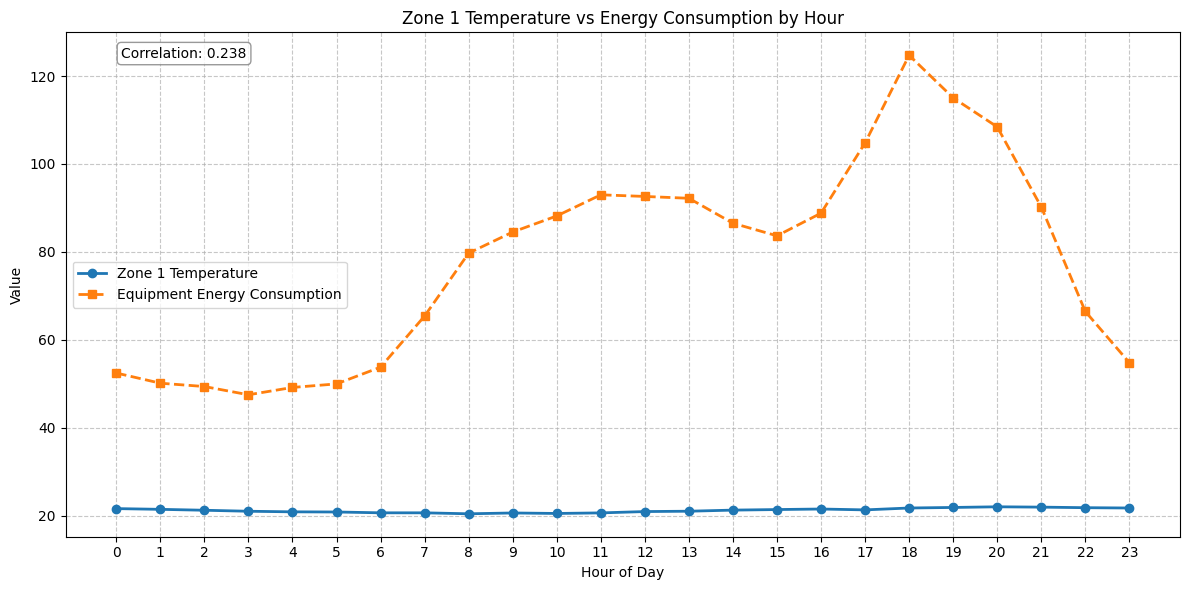

In [66]:
# Plot zone1 temperature and energy consumption by hour
# Group by hour and calculate mean values
hourly_data = raw_df.groupby('hour')[['zone1_temperature', 'equipment_energy_consumption']].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_data.index, hourly_data['zone1_temperature'], marker='o', linestyle='-', 
         linewidth=2, label='Zone 1 Temperature')
plt.plot(hourly_data.index, hourly_data['equipment_energy_consumption'], marker='s', linestyle='--', 
         linewidth=2, label='Equipment Energy Consumption')
plt.title('Zone 1 Temperature vs Energy Consumption by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Value')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(0, 24))
plt.legend()

# Calculate and display correlation
correlation = raw_df['zone1_temperature'].corr(raw_df['equipment_energy_consumption'], method='spearman')
plt.annotate(f'Correlation: {correlation:.3f}', 
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

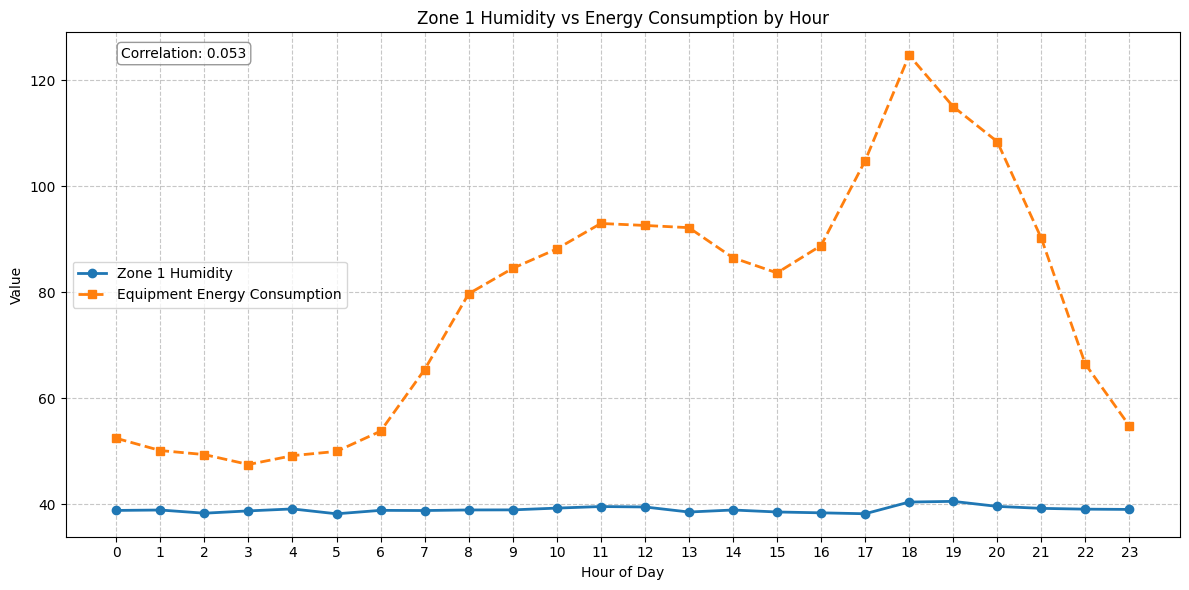

In [67]:
# Plot zone1 humidity and energy consumption by hour
# Group by hour and calculate mean values
hourly_data_humidity = raw_df.groupby('hour')[['zone1_humidity', 'equipment_energy_consumption']].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_data_humidity.index, hourly_data_humidity['zone1_humidity'], marker='o', linestyle='-', 
         linewidth=2, label='Zone 1 Humidity')
plt.plot(hourly_data_humidity.index, hourly_data_humidity['equipment_energy_consumption'], marker='s', linestyle='--', 
         linewidth=2, label='Equipment Energy Consumption')
plt.title('Zone 1 Humidity vs Energy Consumption by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Value')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(0, 24))
plt.legend()

# Calculate and display correlation
correlation_humidity = raw_df['zone1_humidity'].corr(raw_df['equipment_energy_consumption'],method='spearman')
plt.annotate(f'Correlation: {correlation_humidity:.3f}', 
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()


In [68]:
#As we can see that there no relation between the zone1 humidity and the energy consumption and same with 
#And same with temp also we can see that correlation is very low


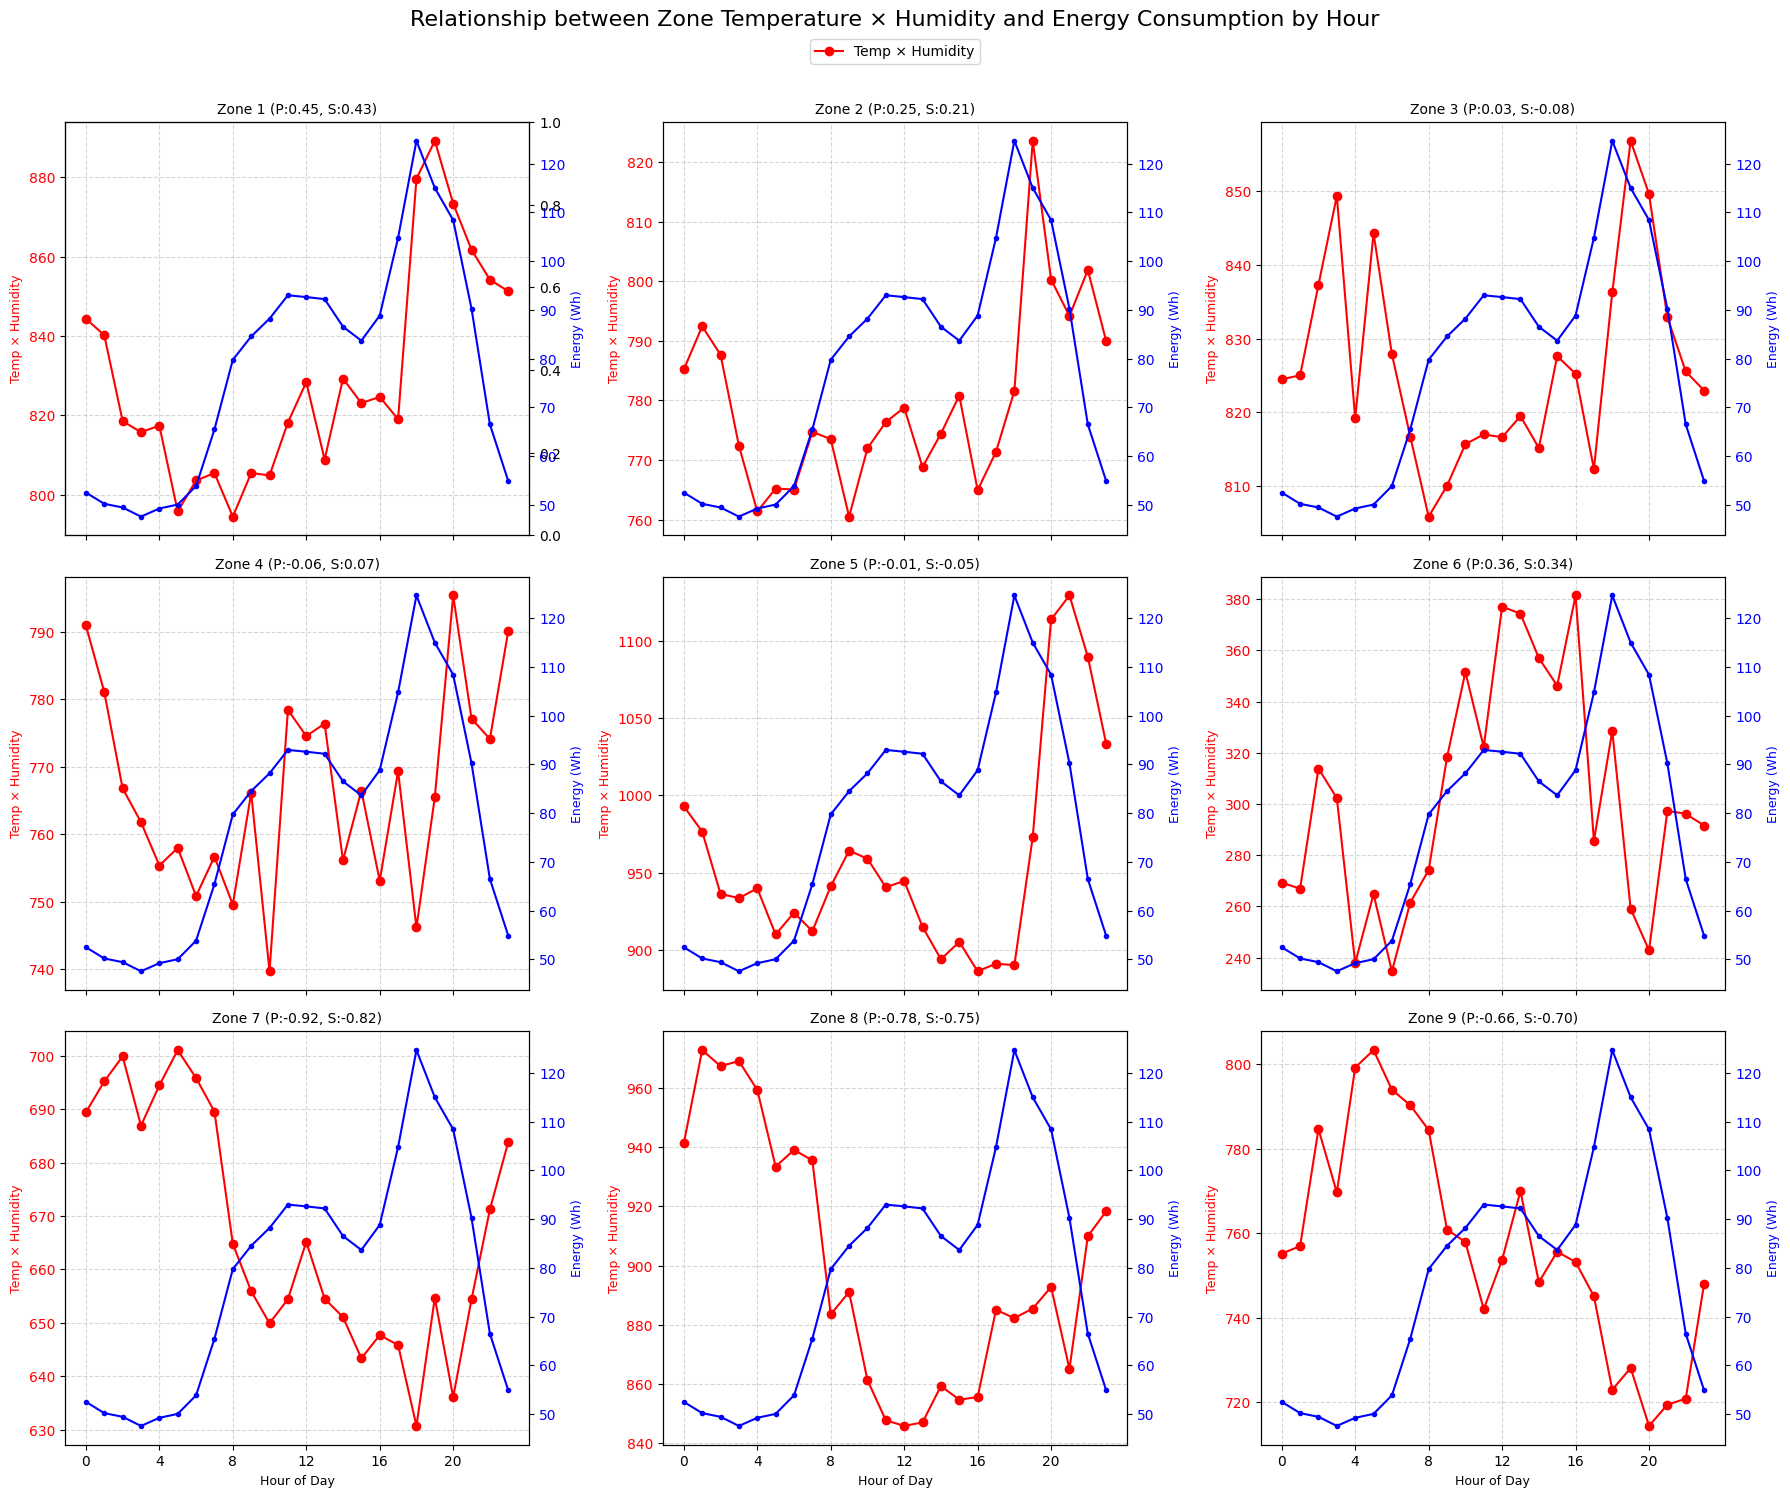

Correlation Summary (Temperature × Humidity vs Energy Consumption):
 Zone     Pearson       Spearman    
------------------------------------------------------------
  1        0.449          0.425     
  2        0.251          0.209     
  3        0.031         -0.077     
  4       -0.060          0.070     
  5       -0.008         -0.048     
  6        0.360          0.337     
  7       -0.925         -0.819     
  8       -0.782         -0.748     
  9       -0.662         -0.697     


In [69]:
# Create a function to analyze all zones in a single plot
def analyze_all_zones():
    # Create a figure with subplots in a grid
    fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharex=True)
    axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing
    
    # Store correlation values for summary
    correlations = []
    
    # Create columns for temperature-humidity products for each zone
    for zone_num in range(1, 10):  # Zones 1-9
        raw_df[f'zone{zone_num}_temp_humidity'] = raw_df[f'zone{zone_num}_temperature'] * raw_df[f'zone{zone_num}_humidity']
    
    # Analyze each zone
    for zone_num in range(1, 10):  # Zones 1-9
        # Calculate hourly averages
        hourly_zone = raw_df.groupby('hour').agg({
            f'zone{zone_num}_temperature': 'mean',
            f'zone{zone_num}_humidity': 'mean',
            f'zone{zone_num}_temp_humidity': 'mean',
            'equipment_energy_consumption': 'mean'
        }).reset_index()
        
        # Calculate correlations
        pearson_corr = hourly_zone[f'zone{zone_num}_temp_humidity'].corr(hourly_zone['equipment_energy_consumption'])
        spearman_corr = hourly_zone[f'zone{zone_num}_temp_humidity'].corr(hourly_zone['equipment_energy_consumption'], method='spearman')
        
        # Store correlation values
        correlations.append((zone_num, pearson_corr, spearman_corr))
        
        # Get the current subplot
        ax1 = axes[zone_num-1]
        
        # Plot temperature-humidity product
        ax1.plot(hourly_zone['hour'], hourly_zone[f'zone{zone_num}_temp_humidity'], 
                color='red', marker='o', label=f'Temp × Humidity', linewidth=1.5)
        ax1.set_ylabel('Temp × Humidity', color='red', fontsize=9)
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.grid(True, linestyle='--', alpha=0.5)
        ax1.set_xticks(range(0, 24, 4))  # Show fewer x-ticks for clarity
        
        # Create second y-axis for energy consumption
        ax2 = ax1.twinx()
        ax2.plot(hourly_zone['hour'], hourly_zone['equipment_energy_consumption'],
                color='blue', marker='.', label='Energy', linewidth=1.5)
        ax2.set_ylabel('Energy (Wh)', color='blue', fontsize=9)
        ax2.tick_params(axis='y', labelcolor='blue')
        
        # Add title with correlations
        ax1.set_title(f'Zone {zone_num} (P:{pearson_corr:.2f}, S:{spearman_corr:.2f})', fontsize=10)
        
        # Only add x-label to bottom plots
        if zone_num > 6:
            ax1.set_xlabel('Hour of Day', fontsize=9)
    
    # Add a common legend
    lines1, labels1 = axes[0].get_legend_handles_labels()
    lines2, labels2 = axes[0].twinx().get_legend_handles_labels()
    fig.legend(lines1 + lines2, labels1 + labels2, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.98))
    
    # Add an overall title
    plt.suptitle('Relationship between Zone Temperature × Humidity and Energy Consumption by Hour', 
                fontsize=16, y=0.995)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for the suptitle
    plt.show()
    
    # Print correlation summary
    print("Correlation Summary (Temperature × Humidity vs Energy Consumption):")
    print("=" * 60)
    print(f"{'Zone':^6}{'Pearson':^15}{'Spearman':^15}")
    print("-" * 60)
    for zone, p_corr, s_corr in correlations:
        print(f"{zone:^6}{p_corr:^15.3f}{s_corr:^15.3f}")
    print("=" * 60)

# Analyze all zones
analyze_all_zones()


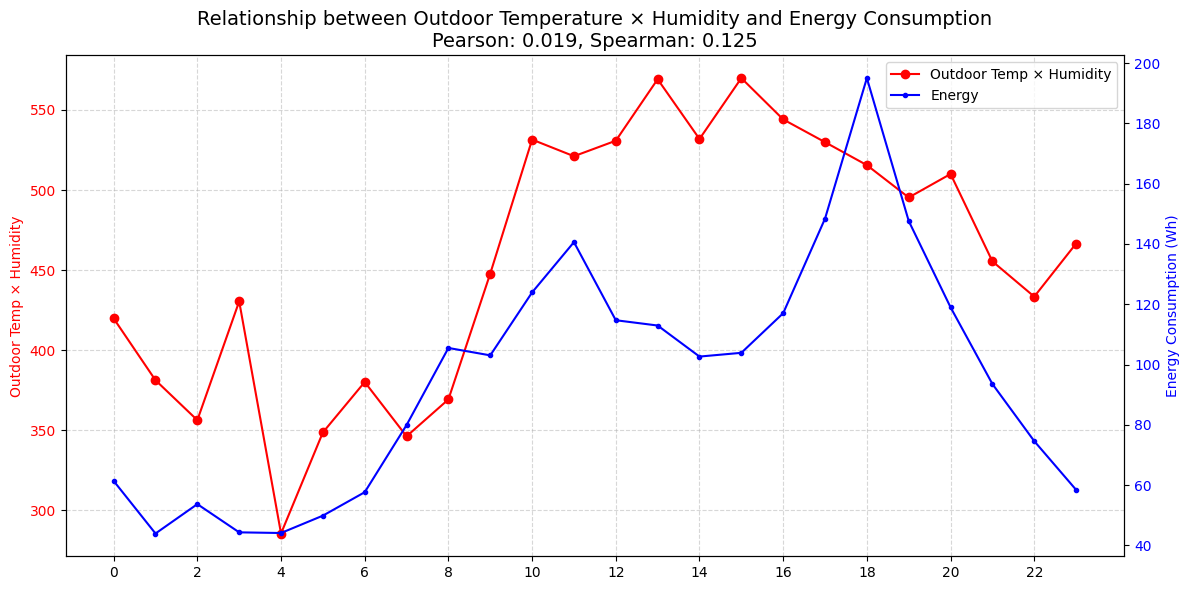


Outdoor Temperature × Humidity vs Energy Consumption Correlation:
Pearson correlation: 0.019
Spearman correlation: 0.125


In [70]:
# Analyze outdoor temperature × humidity relationship with energy consumption
def analyze_outdoor_temp_humidity():
    # Create a copy of the data to avoid modifying the original
    df_outdoor = processed_df.copy()
    
    # Calculate the product of outdoor temperature and humidity
    df_outdoor['outdoor_temp_humidity_product'] = df_outdoor['outdoor_temperature'] * df_outdoor['outdoor_humidity']
    
    # Convert timestamp to hour
    df_outdoor['hour'] = df_outdoor['timestamp'].dt.hour
    
    # Group by hour and calculate mean values
    hourly_outdoor = df_outdoor.groupby('hour').agg({
        'outdoor_temp_humidity_product': 'mean',
        'equipment_energy_consumption': 'mean'
    }).reset_index()
    
    # Calculate correlations
    pearson_corr = df_outdoor['outdoor_temp_humidity_product'].corr(df_outdoor['equipment_energy_consumption'], method='pearson')
    spearman_corr = df_outdoor['outdoor_temp_humidity_product'].corr(df_outdoor['equipment_energy_consumption'], method='spearman')
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # First y-axis for temperature × humidity product
    ax1 = plt.gca()
    ax1.plot(hourly_outdoor['hour'], hourly_outdoor['outdoor_temp_humidity_product'], 
            color='red', marker='o', label='Outdoor Temp × Humidity', linewidth=1.5)
    ax1.set_ylabel('Outdoor Temp × Humidity', color='red', fontsize=10)
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.set_xticks(range(0, 24, 2))
    
    # Second y-axis for energy consumption
    ax2 = ax1.twinx()
    ax2.plot(hourly_outdoor['hour'], hourly_outdoor['equipment_energy_consumption'],
            color='blue', marker='.', label='Energy', linewidth=1.5)
    ax2.set_ylabel('Energy Consumption (Wh)', color='blue', fontsize=10)
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # Add title with correlations
    plt.title(f'Relationship between Outdoor Temperature × Humidity and Energy Consumption\nPearson: {pearson_corr:.3f}, Spearman: {spearman_corr:.3f}', 
              fontsize=14)
    
    # Add x-label
    plt.xlabel('Hour of Day', fontsize=10)
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation values
    print("\nOutdoor Temperature × Humidity vs Energy Consumption Correlation:")
    print(f"Pearson correlation: {pearson_corr:.3f}")
    print(f"Spearman correlation: {spearman_corr:.3f}")

# Run the outdoor analysis
analyze_outdoor_temp_humidity()


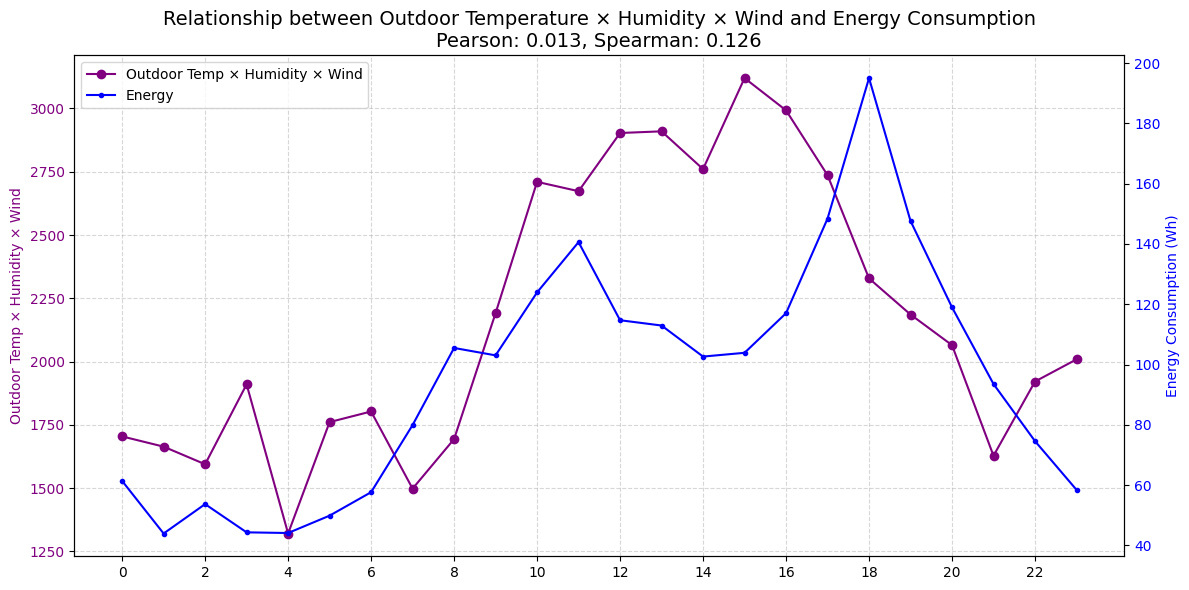


Outdoor Temperature × Humidity × Wind vs Energy Consumption Correlation:
Pearson correlation: 0.013
Spearman correlation: 0.126

Comparison with Temperature × Humidity (without Wind):
Temp × Humidity only - Pearson: 0.019, Spearman: 0.125
Temp × Humidity × Wind - Pearson: 0.013, Spearman: 0.126
Difference - Pearson: -0.006, Spearman: 0.001


In [71]:
def analyze_outdoor_temp_humidity_wind():
    """
    Analyze the relationship between outdoor temperature × humidity × wind speed and energy consumption
    """
    # Create a new feature: temperature × humidity × wind speed
    # Using the already processed dataframe
    processed_df['outdoor_temp_humidity_product'] = processed_df['outdoor_temperature'] * processed_df['outdoor_humidity']
    processed_df['outdoor_temp_humidity_wind_product'] = processed_df['outdoor_temperature'] * processed_df['outdoor_humidity'] * processed_df['wind_speed']
    
    # Group by hour for visualization
    hourly_outdoor = processed_df.groupby(processed_df['timestamp'].dt.hour).agg({
        'outdoor_temp_humidity_wind_product': 'mean',
        'equipment_energy_consumption': 'mean'
    }).reset_index()
    hourly_outdoor.rename(columns={'timestamp': 'hour'}, inplace=True)
    
    # Calculate correlations
    pearson_corr = processed_df['outdoor_temp_humidity_wind_product'].corr(processed_df['equipment_energy_consumption'], method='pearson')
    spearman_corr = processed_df['outdoor_temp_humidity_wind_product'].corr(processed_df['equipment_energy_consumption'], method='spearman')
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # First y-axis for temperature × humidity × wind speed product
    ax1 = plt.gca()
    ax1.plot(hourly_outdoor['hour'], hourly_outdoor['outdoor_temp_humidity_wind_product'], 
            color='purple', marker='o', label='Outdoor Temp × Humidity × Wind', linewidth=1.5)
    ax1.set_ylabel('Outdoor Temp × Humidity × Wind', color='purple', fontsize=10)
    ax1.tick_params(axis='y', labelcolor='purple')
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.set_xticks(range(0, 24, 2))
    
    # Second y-axis for energy consumption
    ax2 = ax1.twinx()
    ax2.plot(hourly_outdoor['hour'], hourly_outdoor['equipment_energy_consumption'],
            color='blue', marker='.', label='Energy', linewidth=1.5)
    ax2.set_ylabel('Energy Consumption (Wh)', color='blue', fontsize=10)
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # Add title with correlations
    plt.title(f'Relationship between Outdoor Temperature × Humidity × Wind and Energy Consumption\nPearson: {pearson_corr:.3f}, Spearman: {spearman_corr:.3f}', 
              fontsize=14)
    
    # Add x-label
    plt.xlabel('Hour of Day', fontsize=10)
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation values
    print("\nOutdoor Temperature × Humidity × Wind vs Energy Consumption Correlation:")
    print(f"Pearson correlation: {pearson_corr:.3f}")
    print(f"Spearman correlation: {spearman_corr:.3f}")
    
    # Compare with previous analysis
    print("\nComparison with Temperature × Humidity (without Wind):")
    pearson_no_wind = processed_df['outdoor_temp_humidity_product'].corr(processed_df['equipment_energy_consumption'], method='pearson')
    spearman_no_wind = processed_df['outdoor_temp_humidity_product'].corr(processed_df['equipment_energy_consumption'], method='spearman')
    
    print(f"Temp × Humidity only - Pearson: {pearson_no_wind:.3f}, Spearman: {spearman_no_wind:.3f}")
    print(f"Temp × Humidity × Wind - Pearson: {pearson_corr:.3f}, Spearman: {spearman_corr:.3f}")
    print(f"Difference - Pearson: {pearson_corr - pearson_no_wind:.3f}, Spearman: {spearman_corr - spearman_no_wind:.3f}")

# Run the outdoor analysis with wind speed
analyze_outdoor_temp_humidity_wind()



In [72]:
#As we can see that after combining two or more features the correlation is increased


### In Hour format


In [73]:
processed_df.info()








<class 'pandas.core.frame.DataFrame'>
Index: 14919 entries, 1 to 16856
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   timestamp                           14919 non-null  datetime64[ns]
 1   equipment_energy_consumption        14919 non-null  float64       
 2   lighting_energy                     14919 non-null  float64       
 3   zone1_temperature                   14919 non-null  float64       
 4   zone1_humidity                      14919 non-null  float64       
 5   zone2_temperature                   14919 non-null  float64       
 6   zone2_humidity                      14919 non-null  float64       
 7   zone3_temperature                   14919 non-null  float64       
 8   zone3_humidity                      14919 non-null  float64       
 9   zone4_temperature                   14919 non-null  float64       
 10  zone4_humidity             

In [74]:
# Aggregate data to hourly intervals
# First, ensure timestamp is a datetime type
processed_df['timestamp'] = pd.to_datetime(processed_df['timestamp'])

# Create a new column with just the hour component
processed_df['date_hour'] = processed_df['timestamp'].dt.floor('H')

# List of columns to aggregate
energy_columns = ['equipment_energy_consumption', 'lighting_energy']
temperature_humidity_columns = [
    'zone1_temperature', 'zone1_humidity', 
    'zone2_temperature', 'zone2_humidity',
    'zone3_temperature', 'zone3_humidity',
    'zone4_temperature', 'zone4_humidity',
    'zone5_temperature', 'zone5_humidity',
    'zone6_temperature', 'zone6_humidity',
    'zone7_temperature', 'zone7_humidity',
    'zone8_temperature', 'zone8_humidity',
    'zone9_temperature', 'zone9_humidity'
]
outdoor_columns = [
    'outdoor_temperature', 'atmospheric_pressure', 
    'outdoor_humidity', 'wind_speed', 
    'visibility_index', 'dew_point'
]

# Aggregate data by hour
# - Sum energy consumption values
# - Average temperature, humidity, and outdoor measurements
hourly_df = processed_df.groupby('date_hour').agg(
    {col: 'sum' for col in energy_columns} | 
    {col: 'mean' for col in temperature_humidity_columns + outdoor_columns}
).reset_index()






hourly_df.to_csv('training_data.csv', index=False)



C:\Users\mahob\AppData\Local\Temp\ipykernel_31088\463164832.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  processed_df['date_hour'] = processed_df['timestamp'].dt.floor('H')


In [75]:
# Create new features by multiplying temperature and humidity for each zone
for i in range(1, 10):  # Zones 1 through 9
    zone_temp_col = f'zone{i}_temperature'
    zone_humid_col = f'zone{i}_humidity'
    new_col_name = f'zone{i}_temp_humid'
    
    # Multiply temperature and humidity for each zone
    processed_df[new_col_name] = processed_df[zone_temp_col] * processed_df[zone_humid_col]
    
    # Also create the same features in the hourly aggregated data
    hourly_df[new_col_name] = hourly_df[zone_temp_col] * hourly_df[zone_humid_col]



# Update the training data CSV with the new features
hourly_df.to_csv('training_data.csv', index=False)


In [76]:
hourly_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2806 entries, 0 to 2805
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date_hour                     2806 non-null   datetime64[ns]
 1   equipment_energy_consumption  2806 non-null   float64       
 2   lighting_energy               2806 non-null   float64       
 3   zone1_temperature             2806 non-null   float64       
 4   zone1_humidity                2806 non-null   float64       
 5   zone2_temperature             2806 non-null   float64       
 6   zone2_humidity                2806 non-null   float64       
 7   zone3_temperature             2806 non-null   float64       
 8   zone3_humidity                2806 non-null   float64       
 9   zone4_temperature             2806 non-null   float64       
 10  zone4_humidity                2806 non-null   float64       
 11  zone5_temperature             

In [77]:
hourly_df.describe()

,date_hour,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,...,dew_point,zone1_temp_humid,zone2_temp_humid,zone3_temp_humid,zone4_temp_humid,zone5_temp_humid,zone6_temp_humid,zone7_temp_humid,zone8_temp_humid,zone9_temp_humid
count,2806,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,...,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000
mean,2016-03-10 15:28:34.041339904,508.485791,26.262466,21.251980,39.063129,19.798922,39.519330,21.661059,38.148280,20.231443,...,2.746603,829.972592,781.085458,825.578839,765.574947,958.155076,308.032106,666.859815,901.243668,758.136445
min,2016-01-11 17:00:00,-1399.132822,0.000000,15.529470,0.178333,13.376690,5.465000,15.339866,8.660667,12.367545,...,-10.166349,3.771842,131.148383,201.973643,180.727052,-3.342858,-2009.511004,-712.807025,91.143213,7.003469
25%,2016-02-09 22:15:00,250.000000,0.000000,20.457229,36.547451,18.534092,37.252441,20.485802,36.115853,19.170281,...,0.302083,761.249601,711.298116,759.751305,686.956439,835.408788,97.277075,582.079021,818.849126,696.651044
50%,2016-03-10 03:30:00,330.000000,0.000000,21.361261,38.975799,19.660848,40.028333,21.727569,38.139238,20.301667,...,2.681667,833.908597,783.473417,833.624316,768.209346,933.749936,265.180875,676.311670,899.593835,762.776569
75%,2016-04-08 08:45:00,640.000000,40.000000,22.156820,42.550000,20.941435,42.975752,22.810833,41.328097,21.395292,...,5.374583,908.146398,860.838156,902.782994,843.435622,1043.773919,474.808570,759.303443,997.192811,838.571740
max,2016-12-01 15:00:00,3650.000000,270.000000,27.058644,58.373097,27.364054,55.179534,27.929593,54.050636,26.304845,...,18.439636,1296.093767,1278.890737,1223.167540,1305.459062,2007.114799,2736.563598,1136.825395,1664.430307,1253.960224
std,NaN,554.513082,42.381020,1.441119,5.238528,1.946460,5.294919,1.701040,5.126760,1.808649,...,3.916601,124.346786,122.568522,123.834779,127.247476,226.381637,366.282012,133.859995,150.976328,122.699754


In [78]:
# Check for negative values in the hourly dataframe
print("Counting negative values in each column of hourly_df:")
negative_counts = {}

for column in hourly_df.columns:
    # Skip the date_hour column since it's not numeric
    if column == 'date_hour':
        continue
    
    # Count negative values in the column
    neg_count = (hourly_df[column] < 0).sum()
    
    # Only include columns with at least one negative value
    if neg_count > 0:
        negative_counts[column] = neg_count

# Display the results
for column, count in negative_counts.items():
    print(f"{column}: {count} negative values")

# Calculate the total percentage of negative values
total_cells = (len(hourly_df.columns) - 1) * len(hourly_df)  # Exclude date_hour column
total_negative = sum(negative_counts.values())
percentage_negative = (total_negative / total_cells) * 100

print(f"\nTotal negative values: {total_negative}")
print(f"Percentage of negative values: {percentage_negative:.2f}%")

# Show some examples of rows with negative values for key columns
if 'equipment_energy_consumption' in negative_counts and negative_counts['equipment_energy_consumption'] > 0:
    print("\nSample rows with negative equipment_energy_consumption:")
    print(hourly_df[hourly_df['equipment_energy_consumption'] < 0].head())

# Remove rows with negative values as they don't comprise of major data
print("\nRemoving rows with negative values...")
original_row_count = len(hourly_df)

# Create a mask to identify rows with any negative values in numeric columns
negative_mask = pd.Series(False, index=hourly_df.index)
for column in hourly_df.columns:
    if column != 'date_hour':  # Skip non-numeric columns
        negative_mask = negative_mask | (hourly_df[column] < 0)

# Remove rows with negative values
hourly_df = hourly_df[~negative_mask]

# Report the number of rows removed
removed_rows = original_row_count - len(hourly_df)
print(f"Removed {removed_rows} rows ({(removed_rows/original_row_count)*100:.2f}% of data) containing negative values")
print(f"Remaining rows: {len(hourly_df)}")


Counting negative values in each column of hourly_df:
equipment_energy_consumption: 127 negative values
zone5_humidity: 1 negative values
zone6_temperature: 309 negative values
zone6_humidity: 58 negative values
zone7_humidity: 1 negative values
outdoor_temperature: 257 negative values
outdoor_humidity: 2 negative values
wind_speed: 99 negative values
visibility_index: 9 negative values
dew_point: 608 negative values
zone5_temp_humid: 1 negative values
zone6_temp_humid: 359 negative values
zone7_temp_humid: 1 negative values

Total negative values: 1832
Percentage of negative values: 1.87%

Sample rows with negative equipment_energy_consumption:
              date_hour  equipment_energy_consumption  lighting_energy  \
34  2016-01-13 03:00:00                   -804.566411              0.0   
42  2016-01-13 11:00:00                   -704.566411             40.0   
76  2016-01-14 21:00:00                  -1399.132822            100.0   
84  2016-01-15 05:00:00                   -834.566

In [79]:
# Create outdoor temperature-humidity product feature
hourly_df['outdoor_temp_humid'] = hourly_df['outdoor_temperature'] * hourly_df['outdoor_humidity']

# Drop individual zone temperature, humidity, and other specified columns from hourly_df
columns_to_drop = [
    'zone1_temperature', 'zone1_humidity',
    'zone2_temperature', 'zone2_humidity',
    'zone3_temperature', 'zone3_humidity',
    'zone4_temperature', 'zone4_humidity',
    'zone5_temperature', 'zone5_humidity',
    'zone6_temperature', 'zone6_humidity',
    'zone7_temperature', 'zone7_humidity',
    'zone8_temperature', 'zone8_humidity',
    'zone9_temperature', 'zone9_humidity',
    'outdoor_temperature', 'outdoor_humidity',  # Also drop individual outdoor columns
    'atmospheric_pressure',
    'wind_speed',
    'visibility_index',
    'dew_point'
]

# Check which columns actually exist in the dataframe before dropping
columns_to_drop = [col for col in columns_to_drop if col in hourly_df.columns]

# Drop the columns
hourly_df = hourly_df.drop(columns=columns_to_drop)

# Display information about the dataframe after dropping columns
print("Columns dropped from hourly_df:")
print(columns_to_drop)
print("\nRemaining columns in hourly_df:")
print(hourly_df.columns.tolist())

# Update the training data CSV with the reduced feature set
hourly_df.to_csv('training_data.csv', index=False)
print("\nUpdated hourly data with reduced feature set saved to 'training_data.csv'")



Columns dropped from hourly_df:
['zone1_temperature', 'zone1_humidity', 'zone2_temperature', 'zone2_humidity', 'zone3_temperature', 'zone3_humidity', 'zone4_temperature', 'zone4_humidity', 'zone5_temperature', 'zone5_humidity', 'zone6_temperature', 'zone6_humidity', 'zone7_temperature', 'zone7_humidity', 'zone8_temperature', 'zone8_humidity', 'zone9_temperature', 'zone9_humidity', 'outdoor_temperature', 'outdoor_humidity', 'atmospheric_pressure', 'wind_speed', 'visibility_index', 'dew_point']

Remaining columns in hourly_df:
['date_hour', 'equipment_energy_consumption', 'lighting_energy', 'zone1_temp_humid', 'zone2_temp_humid', 'zone3_temp_humid', 'zone4_temp_humid', 'zone5_temp_humid', 'zone6_temp_humid', 'zone7_temp_humid', 'zone8_temp_humid', 'zone9_temp_humid', 'outdoor_temp_humid']

Updated hourly data with reduced feature set saved to 'training_data.csv'


In [80]:
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1829 entries, 0 to 2804
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date_hour                     1829 non-null   datetime64[ns]
 1   equipment_energy_consumption  1829 non-null   float64       
 2   lighting_energy               1829 non-null   float64       
 3   zone1_temp_humid              1829 non-null   float64       
 4   zone2_temp_humid              1829 non-null   float64       
 5   zone3_temp_humid              1829 non-null   float64       
 6   zone4_temp_humid              1829 non-null   float64       
 7   zone5_temp_humid              1829 non-null   float64       
 8   zone6_temp_humid              1829 non-null   float64       
 9   zone7_temp_humid              1829 non-null   float64       
 10  zone8_temp_humid              1829 non-null   float64       
 11  zone9_temp_humid              1829 

In [81]:
# Divide the data into features (X) and target variable (Y)
# For time series data, we need to be careful about the order of data

# First, let's sort the data by timestamp to ensure chronological order
hourly_df = hourly_df.sort_values('date_hour')

# Define the target variable (Y) - equipment energy consumption
y = hourly_df['equipment_energy_consumption']

# Define the features (X) - all columns except the target
# For time series modeling, we'll keep timestamp as a feature for now
X = hourly_df.drop(columns=['equipment_energy_consumption'])

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

# Display first few rows of features and target
print("\nFirst few rows of features (X):")
print(X.head())

print("\nFirst few rows of target (y):")
print(y.head())

# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Since this is time series data, we should split the data chronologically
# We'll use the train_test_split function but maintain the time order
# by setting shuffle=False
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

print("\nTraining set sizes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print("\nTest set sizes:")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")



Features (X) shape: (1829, 12)
Target (y) shape: (1829,)

First few rows of features (X):
            date_hour  lighting_energy  zone1_temp_humid  zone2_temp_humid  \
0 2016-01-11 17:00:00            180.0       1048.856621        856.201600   
1 2016-01-11 18:00:00            270.0        915.001216        858.950087   
3 2016-01-11 20:00:00            210.0       1009.758858        922.715005   
4 2016-01-11 21:00:00            120.0        794.091181        924.233500   
6 2016-01-11 23:00:00             80.0        953.551583        922.616985   

   zone3_temp_humid  zone4_temp_humid  zone5_temp_humid  zone6_temp_humid  \
0        889.191087       1040.918199        961.902510        547.581986   
1        887.597084       1029.361346        940.044000        539.884267   
3        955.488068        944.724744       1304.040432        474.348249   
4        938.242075        945.339794       1305.655587        481.339012   
6        929.792842        974.557672        983.516725 

In [82]:
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1829 entries, 0 to 2804
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date_hour                     1829 non-null   datetime64[ns]
 1   equipment_energy_consumption  1829 non-null   float64       
 2   lighting_energy               1829 non-null   float64       
 3   zone1_temp_humid              1829 non-null   float64       
 4   zone2_temp_humid              1829 non-null   float64       
 5   zone3_temp_humid              1829 non-null   float64       
 6   zone4_temp_humid              1829 non-null   float64       
 7   zone5_temp_humid              1829 non-null   float64       
 8   zone6_temp_humid              1829 non-null   float64       
 9   zone7_temp_humid              1829 non-null   float64       
 10  zone8_temp_humid              1829 non-null   float64       
 11  zone9_temp_humid              1829 

In [83]:
hourly_df.head()

,date_hour,equipment_energy_consumption,lighting_energy,zone1_temp_humid,zone2_temp_humid,zone3_temp_humid,zone4_temp_humid,zone5_temp_humid,zone6_temp_humid,zone7_temp_humid,zone8_temp_humid,zone9_temp_humid,outdoor_temp_humid
0,2016-01-11 17:00:00,270.0,180.0,1048.856621,856.201600,889.191087,1040.918199,961.902510,547.581986,715.434562,1049.068857,661.947125,575.000000
1,2016-01-11 18:00:00,1000.0,270.0,915.001216,858.950087,887.597084,1029.361346,940.044000,539.884267,731.224639,1078.827235,768.137055,699.334717
3,2016-01-11 20:00:00,750.0,210.0,1009.758858,922.715005,955.488068,944.724744,1304.040432,474.348249,755.807362,1089.432675,765.253351,659.335432
4,2016-01-11 21:00:00,520.0,120.0,794.091181,924.233500,938.242075,945.339794,1305.655587,481.339012,778.659050,571.077920,757.167440,523.004351
6,2016-01-11 23:00:00,250.0,80.0,953.551583,922.616985,929.792842,974.557672,983.516725,496.907592,764.005750,971.538344,762.414600,505.400000



Training Random Forest...
Random Forest - Training RMSE: 176.86, Test RMSE: 415.18
Random Forest - Training R²: 0.8815, Test R²: 0.0318
Random Forest - Test MAE: 302.17

Training Gradient Boosting...
Gradient Boosting - Training RMSE: 357.75, Test RMSE: 408.47
Gradient Boosting - Training R²: 0.5152, Test R²: 0.0629
Gradient Boosting - Test MAE: 276.97

Model Comparison:
           Random Forest  Gradient Boosting
Test RMSE     415.176286         408.466087
Test R²         0.031834           0.062876
Test MAE      302.170092         276.968613


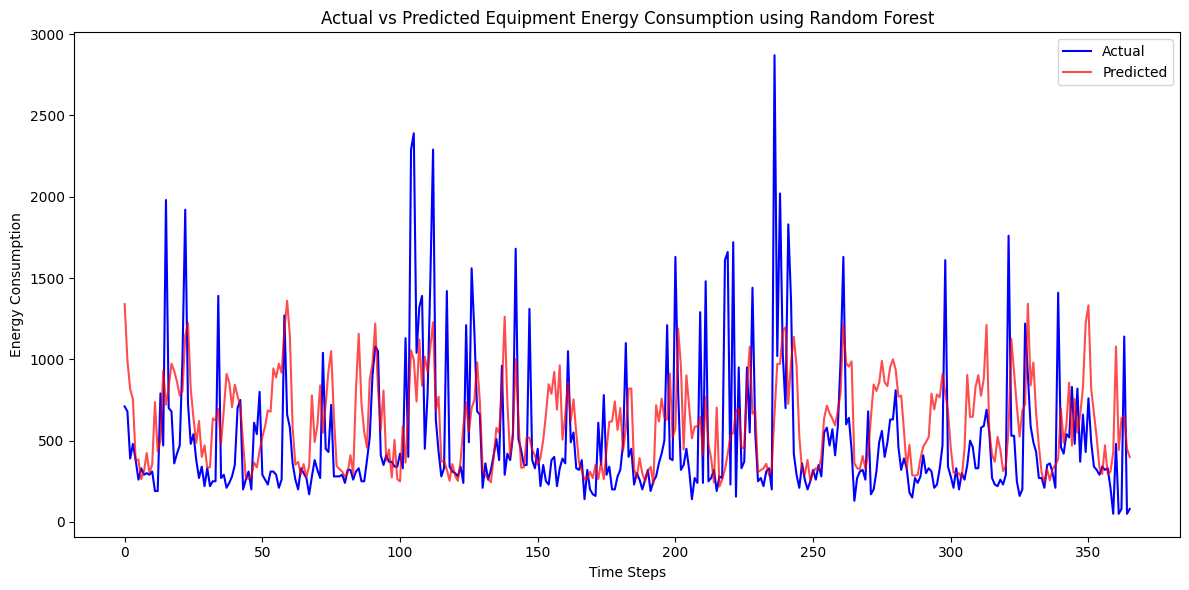

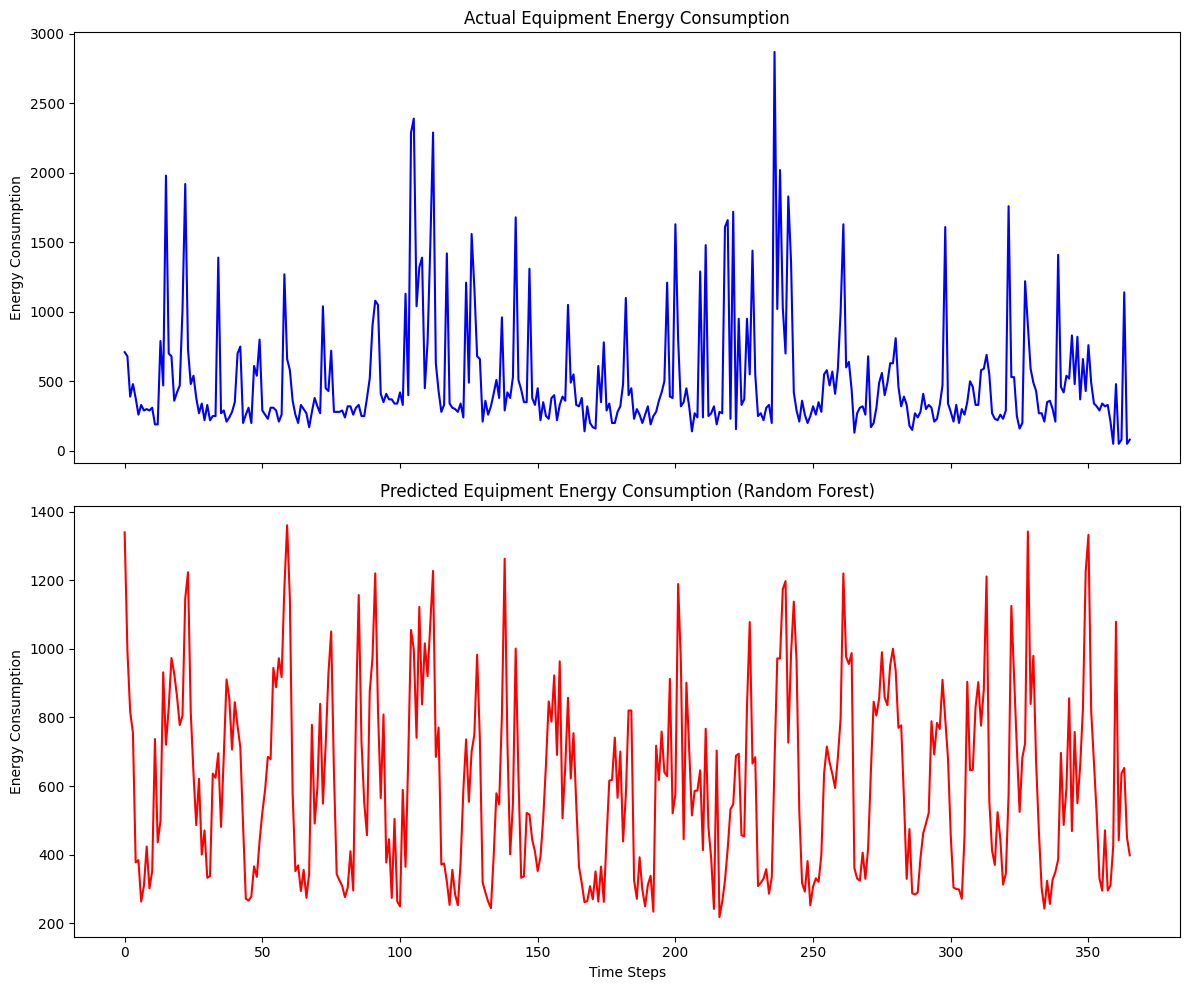

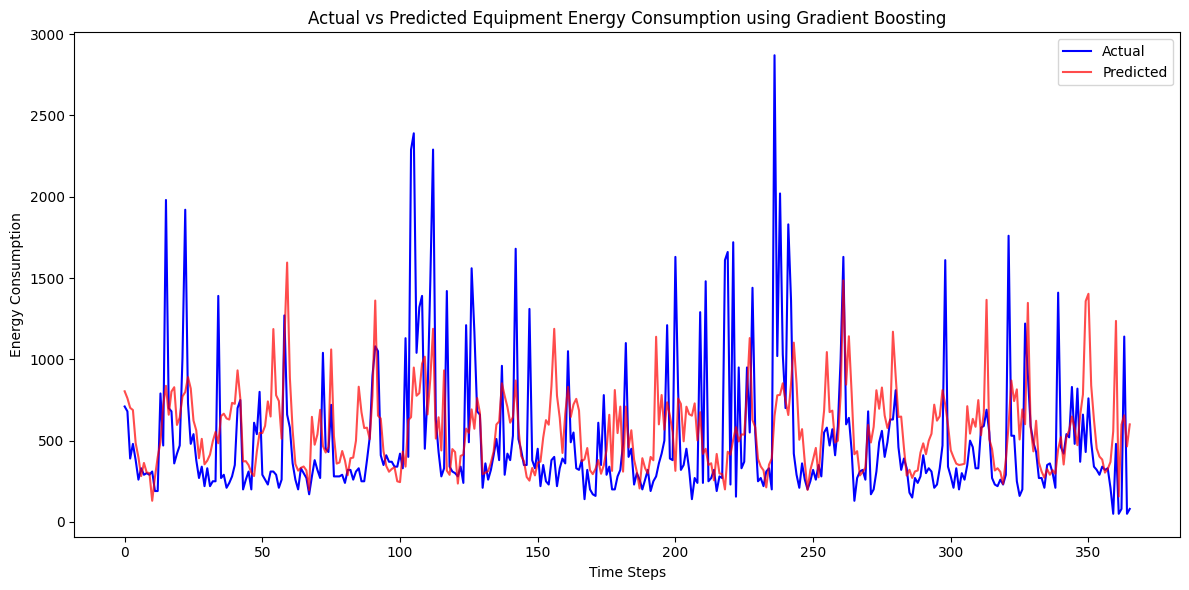

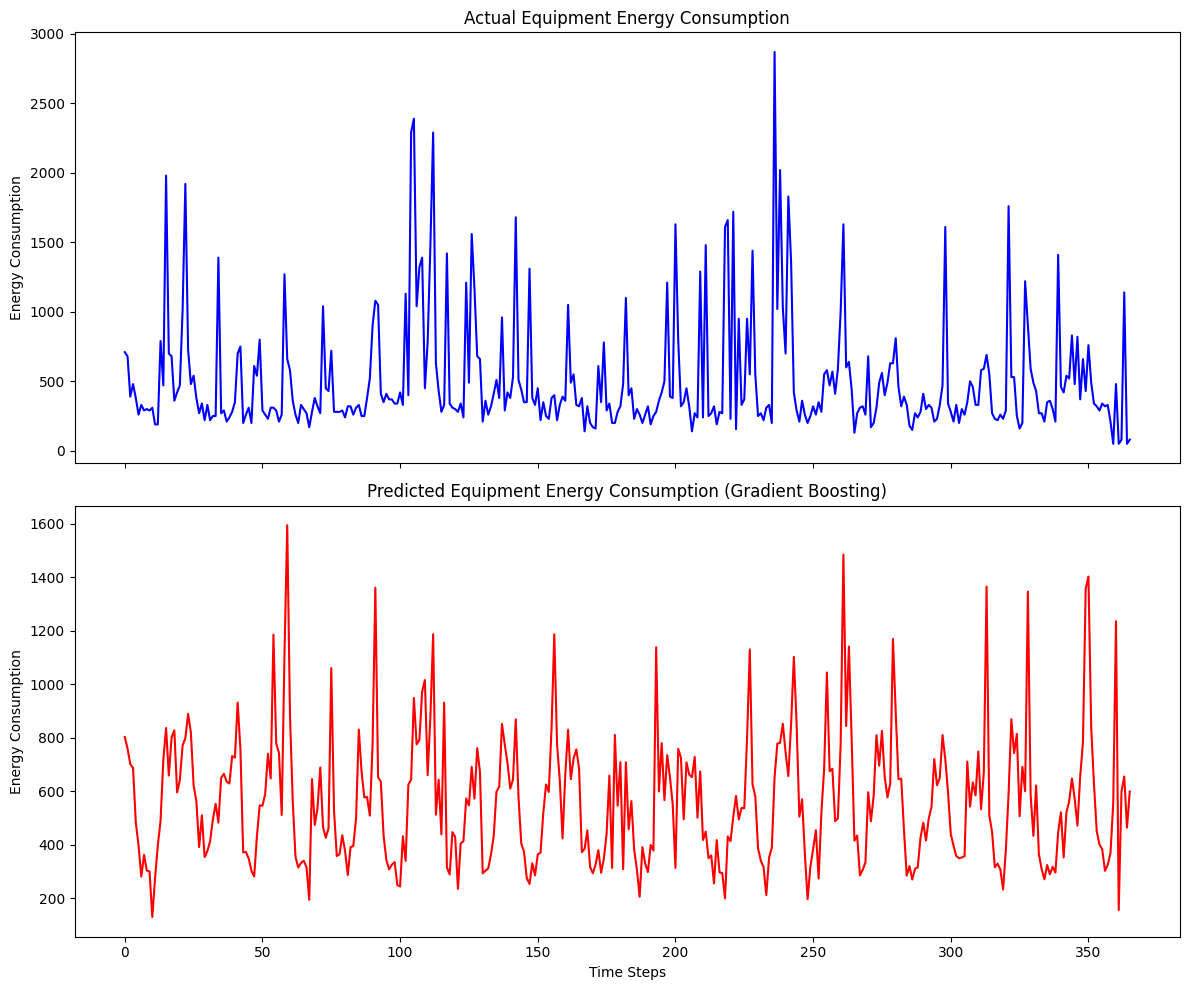

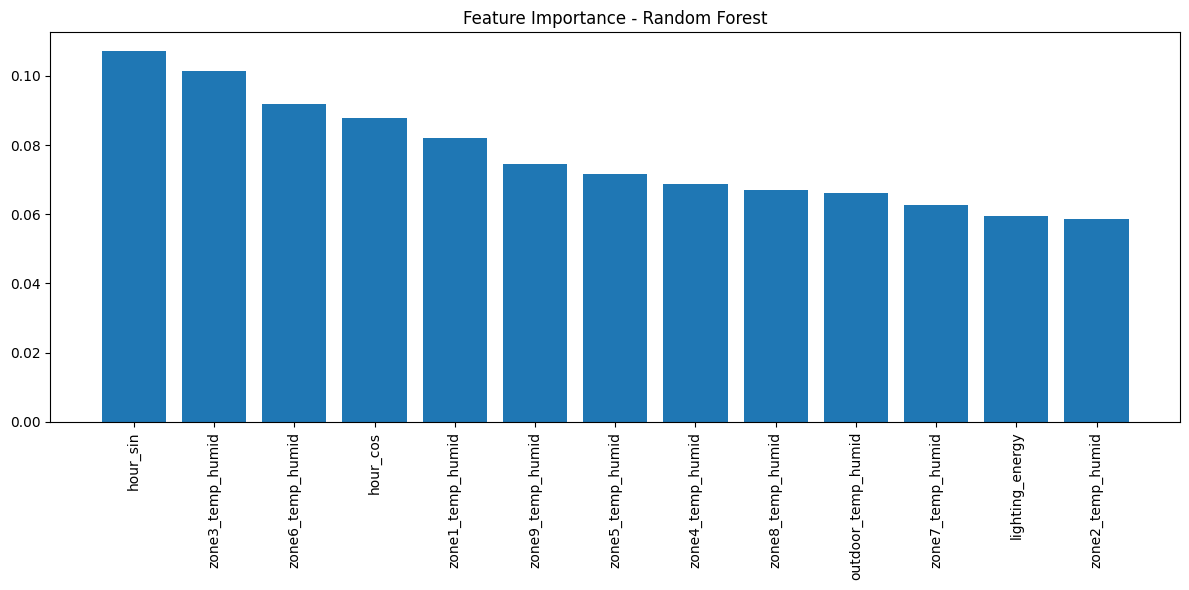

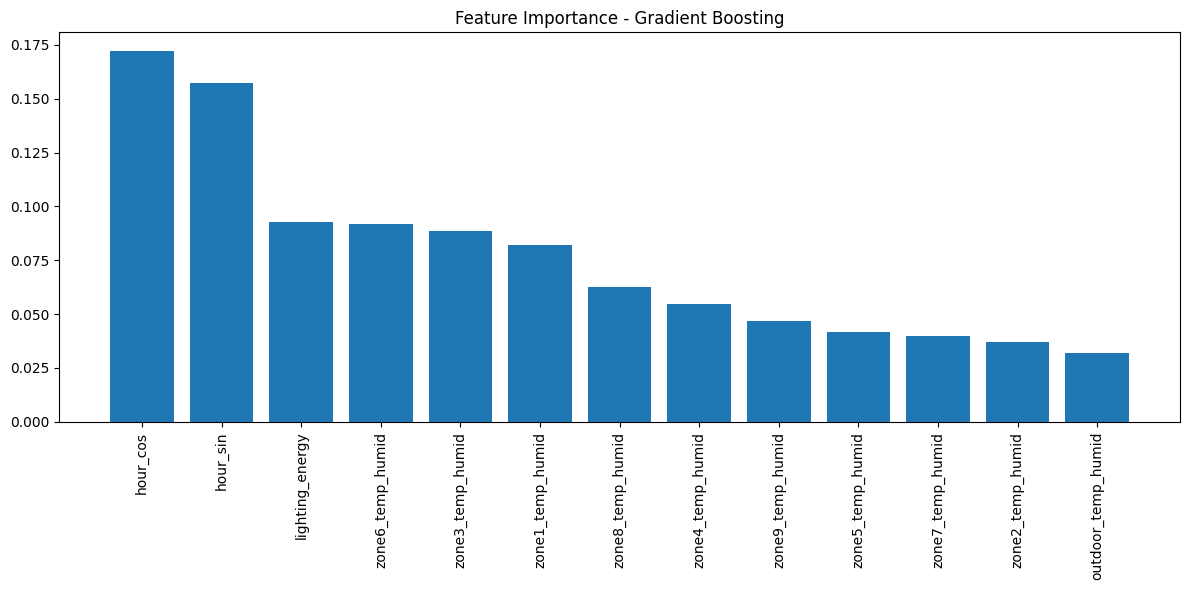

In [84]:
# Import necessary libraries for regression modeling and scaling
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# First, let's handle the date_hour column for modeling
# We'll extract useful time features
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

# Extract time-based features
X_train_processed['hour'] = X_train_processed['date_hour'].dt.hour
X_test_processed['hour'] = X_test_processed['date_hour'].dt.hour

# Add cyclical time features for hour
# Convert hour to its cyclical representation using sine and cosine transformations
X_train_processed['hour_sin'] = np.sin(2 * np.pi * X_train_processed['hour']/24.0)  # Using 24.0 since hours range from 0-23
X_train_processed['hour_cos'] = np.cos(2 * np.pi * X_train_processed['hour']/24.0)
X_test_processed['hour_sin'] = np.sin(2 * np.pi * X_test_processed['hour']/24.0)
X_test_processed['hour_cos'] = np.cos(2 * np.pi * X_test_processed['hour']/24.0)

# Drop the original timestamp column and the raw hour column since we have better cyclical representations
X_train_processed = X_train_processed.drop(columns=['date_hour', 'hour'])
X_test_processed = X_test_processed.drop(columns=['date_hour', 'hour'])

# Apply scaling to the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

# Initialize and train different regression models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Dictionary to store results
results = {}
predictions = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Store predictions for later visualization
    predictions[name] = y_test_pred
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Store results
    results[name] = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae
    }
    
    # Print metrics
    print(f"{name} - Training RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
    print(f"{name} - Training R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"{name} - Test MAE: {test_mae:.2f}")

# Create a comparison table of model performance
import pandas as pd
results_df = pd.DataFrame({
    model_name: {
        'Test RMSE': results[model_name]['test_rmse'],
        'Test R²': results[model_name]['test_r2'],
        'Test MAE': results[model_name]['test_mae']
    } for model_name in results
})

print("\nModel Comparison:")
print(results_df)

# Plot actual vs predicted for each model on separate graphs
for name, y_pred in predictions.items():
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', alpha=0.7)
    plt.title(f'Actual vs Predicted Equipment Energy Consumption using {name}')
    plt.xlabel('Time Steps')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Also plot them on separate subplots for better comparison
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Actual values
    ax1.plot(y_test.values, color='blue')
    ax1.set_title('Actual Equipment Energy Consumption')
    ax1.set_ylabel('Energy Consumption')
    
    # Predicted values
    ax2.plot(y_pred, color='red')
    ax2.set_title(f'Predicted Equipment Energy Consumption ({name})')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Energy Consumption')
    
    plt.tight_layout()
    plt.show()

# Feature importance for tree-based models
for model_name in ['Random Forest', 'Gradient Boosting']:
    if model_name in models:
        model = models[model_name]
        feature_importance = model.feature_importances_
        feature_names = X_train_processed.columns
        
        # Sort features by importance
        indices = np.argsort(feature_importance)[::-1]
        
        # Plot feature importance
        plt.figure(figsize=(12, 6))
        plt.title(f'Feature Importance - {model_name}')
        plt.bar(range(len(indices)), feature_importance[indices], align='center')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()